# Evaluation Metrics for Classification

## Evaluation metrics

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == "yes").astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and dummy model
* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

1132

In [11]:
1132 / 1409

0.8034066713981547

In [18]:
from sklearn.metrics import accuracy_score

In [12]:
thresholds = np.linspace(0,1,21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [22]:
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


Highest score is in the 50% threshold

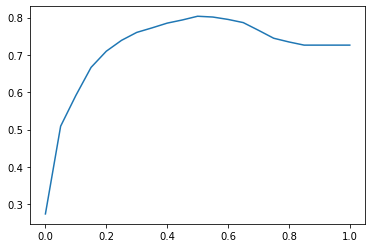

In [15]:
plt.plot(thresholds, scores)

In [24]:
from collections import Counter

In [26]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [28]:
Counter(y_val)

Counter({0: 1023, 1: 386})

## Confusion table
* Different types of errors and correct decisions
* Arranging them in a table

In [29]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [30]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [34]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [35]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [36]:
tp, tn

(210, 922)

In [37]:
fp, fn

(101, 176)

In [39]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

## Precision and Recall

In [40]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

In [46]:
# Precision - Fraction of positive predictions that are correct
p = tp / (tp + fp)
p

0.6752411575562701

In [47]:
# Recall - Fraction of correctly identified positive samples
r = tp / (tp + fn)
r

0.5440414507772021

* Accuracy score can be misleading especially in inbalanced classes. It is useful to look at metrics precision and recall

## ROC Curves

### TPR (True Positive Rate) and FPR (False Positive Rate)
* Try to minimize FPR and maximize TPR

In [51]:
# True Positive Rate
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [52]:
# TPR is same as recall
r

0.5440414507772021

In [50]:
# False Positive Rate
fpr = fp / (tn + fp)
fpr

0.09872922776148582

In [53]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [56]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [57]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [59]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


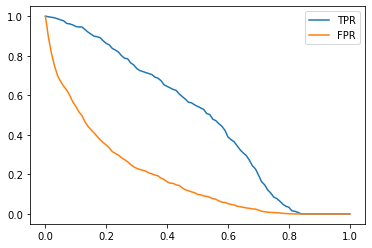

In [60]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random Model

In [62]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [63]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [65]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [66]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [67]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


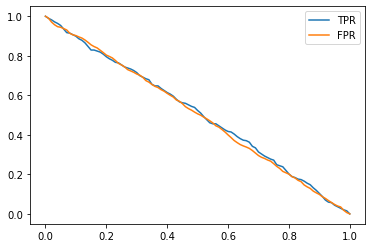

In [68]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal Model

In [69]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [70]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [71]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [73]:
1 - y_val.mean()

0.7260468417317246

In [74]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [75]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


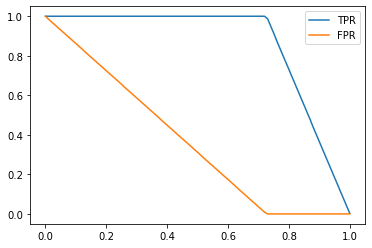

In [76]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

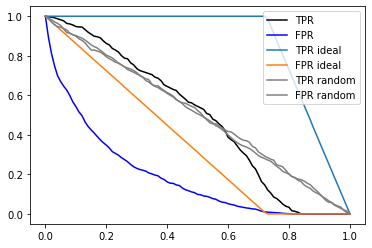

In [78]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

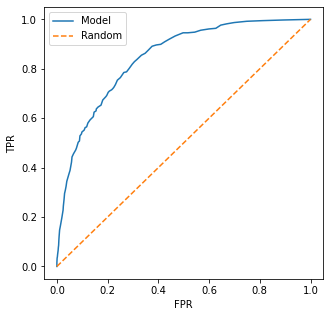

In [80]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [83]:
# Scikit Learn
from sklearn.metrics import roc_curve

In [84]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

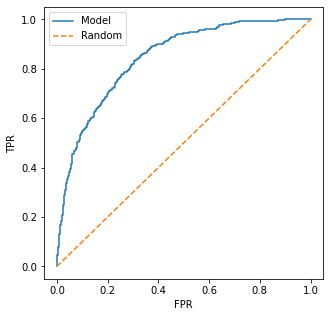

In [85]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## ROC AUC
* Area under the ROC curve - useful metric
* Interpretation of AUC

In [86]:
from sklearn.metrics import auc

In [87]:
auc(fpr, tpr)

0.843850505725819

In [88]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [89]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [90]:
from sklearn.metrics import roc_auc_score

In [91]:
roc_auc_score(y_val, y_pred)

0.843850505725819

> AUC is probability that randomly selected positive example has higher score than randomly selected negative example.

In [92]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [96]:
import random
n = 10000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1
        
success / n

0.8474

In [101]:
n = 50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
(pos[pos_ind] > neg[neg_ind]).mean()

0.84416

## Cross-Validation
* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [127]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [130]:
dv, model = train(df_train, y_train, C=0.001)

In [113]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [106]:
y_pred = predict(df_val, dv, model)

In [107]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x000002573DB62E40>

In [108]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [109]:
len(train_idx), len(val_idx)

(5070, 564)

In [110]:
len(df_full_train)

5634

In [111]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [116]:
!pip install tqdm

In [117]:
from tqdm.auto import tqdm

In [135]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    
    scores = []
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)

        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [136]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## Summary
* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)
* F1 score = 2 x P x R / (P + R)